# [course website](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/)

# Libraries

In [1]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, minmax_scale
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPool2D, Activation, Embedding, LSTM, GRU, Bidirectional, TextVectorization
from tensorflow.keras import mixed_precision, Sequential, layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import random
import zipfile
import io
import os
import pathlib
import datetime
import time
import string
import csv

In [3]:
!wget https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
import TfCommon

--2023-08-20 16:49:15--  https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21969 (21K) [text/plain]
Saving to: ‘TfCommon.py’

TfCommon.py         100%[===================>]  21.45K  --.-KB/s    in 0.001s  

2023-08-20 16:49:15 (34.9 MB/s) - ‘TfCommon.py’ saved [21969/21969]



# Data

## Download

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-08-20 16:49:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.009s  

2023-08-20 16:49:15 (18.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Import (pandas)

In [5]:
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
len(df)

2787

In [8]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


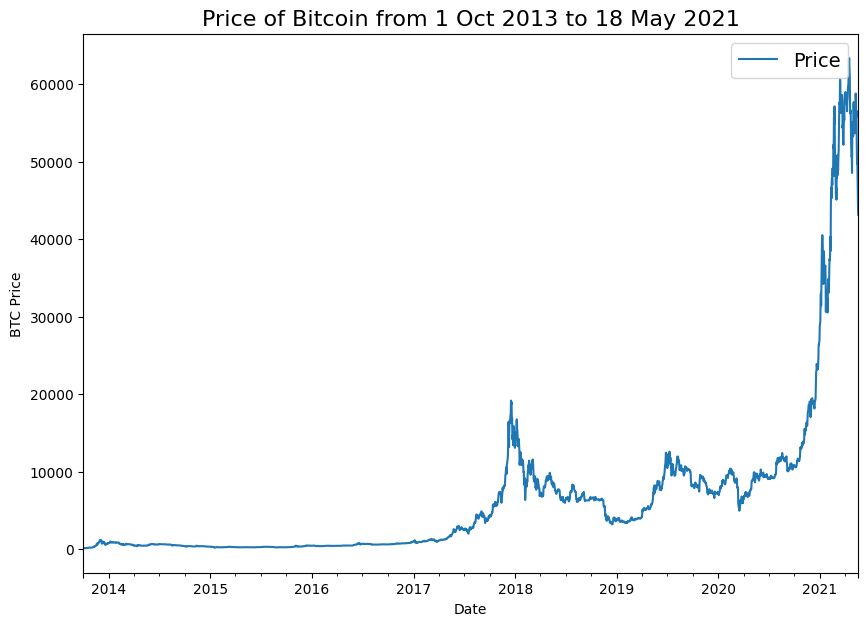

In [9]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Import (csv)

In [10]:
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

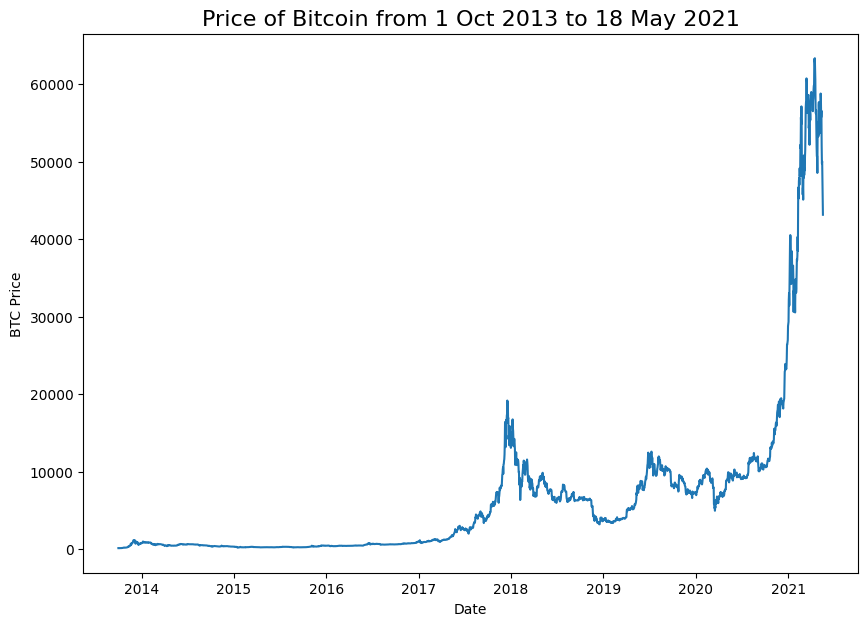

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

## Format Data (1)

In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

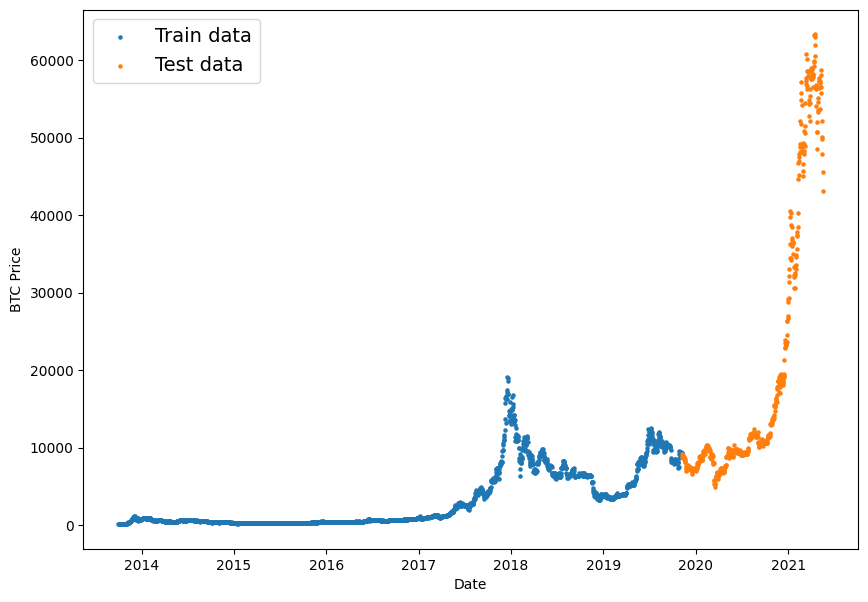

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [15]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

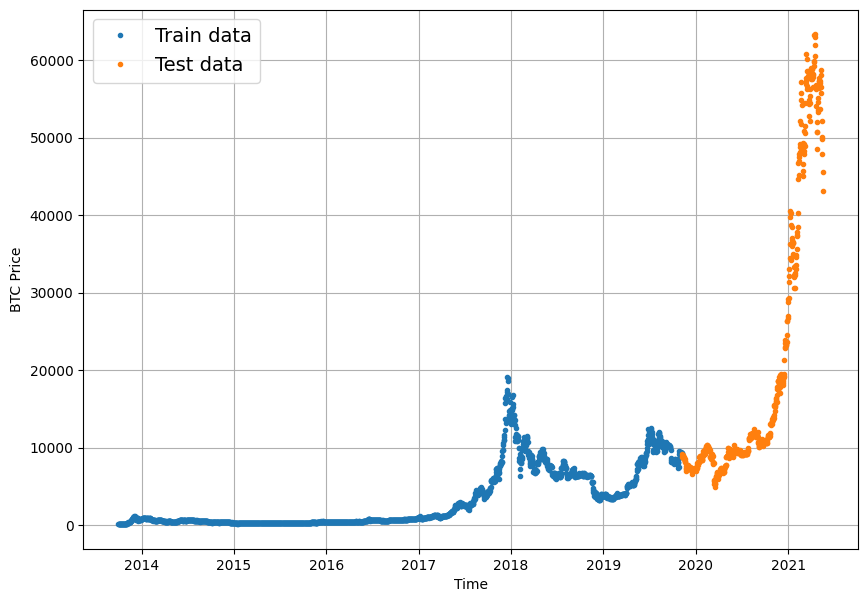

In [16]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Format Data (2)

In [17]:
HORIZON = 1
WINDOW_SIZE = 7

In [18]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [19]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [20]:
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [22]:
print('First 3')
for i in range(3):
  print('-'*20)
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

print('\nLast 3')
for i in range(3):
  print('-'*20)
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

First 3
--------------------
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
--------------------
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
--------------------
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]

Last 3
--------------------
Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
--------------------
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
--------------------
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [23]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  return windows[:split_size], windows[split_size:], labels[:split_size], labels[split_size:]

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [25]:
x=3
print('First 3')
for i in range(x):
  print(np.round(train_windows[i], 2), np.round(train_labels[i], 2))

print('\nLast 3')
for i in range(x):
  print(np.round(train_windows[i-x], 2), np.round(train_labels[i-x], 2))

First 3
[123.65 125.46 108.58 118.67 121.34 120.66 121.8 ] [123.03]
[125.46 108.58 118.67 121.34 120.66 121.8  123.03] [124.05]
[108.58 118.67 121.34 120.66 121.8  123.03 124.05] [125.96]

Last 3
[9226.   9131.41 9197.63 9290.9  9202.42 9369.63 9326.6 ] [9335.75]
[9131.41 9197.63 9290.9  9202.42 9369.63 9326.6  9335.75] [9226.49]
[9197.63 9290.9  9202.42 9369.63 9326.6  9335.75 9226.49] [8794.36]


In [26]:
'Unsqueezed:', np.array_equal(train_labels[:-HORIZON-1], y_train[WINDOW_SIZE:]), 'Squeezed:', np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

('Unsqueezed:', False, 'Squeezed:', True)

In [27]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      save_best_only=True,
      verbose=0
  )

# Model_0 - Naive Forecast (baseline)

In [28]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

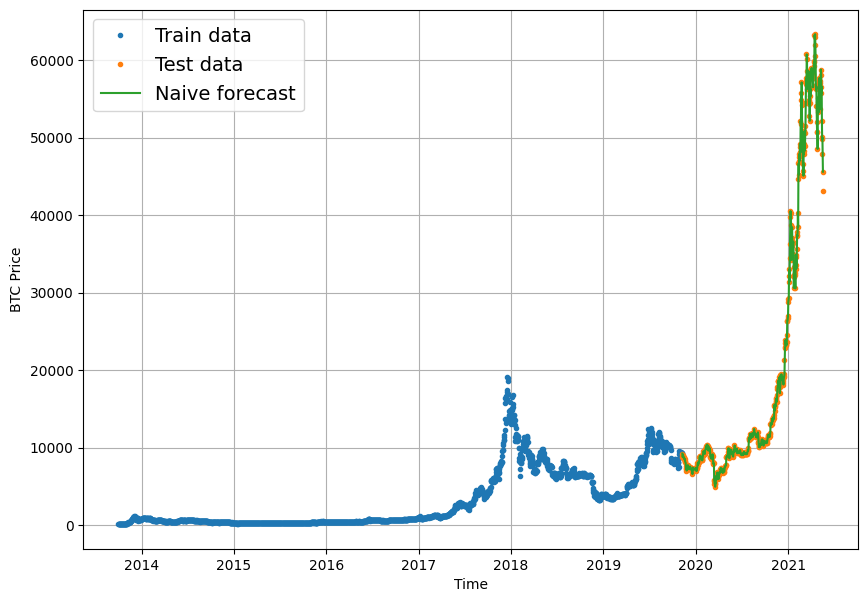

In [29]:
plt.figure(figsize=(10, 7))
TfCommon.plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

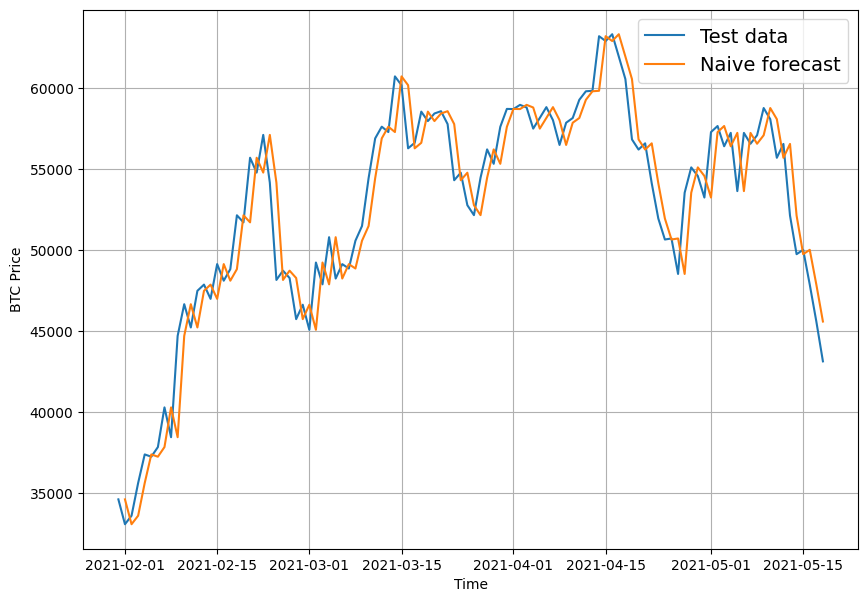

In [30]:
plt.figure(figsize=(10, 7))
offset = 450
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [31]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [32]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [33]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)

In [34]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  ev_dict = {
      'MAE': keras.metrics.mean_absolute_error(y_true, y_pred).numpy(),
      'MASE': mean_absolute_scaled_error(y_true, y_pred).numpy(),
      'MSE': keras.metrics.mean_squared_error(y_true, y_pred).numpy(),
      'rMSE': tf.math.sqrt(keras.metrics.mean_squared_error(y_true, y_pred)).numpy(),
      'MAPE': keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy(),
  }
  return ev_dict

In [35]:
res_m0 =evaluate_preds(y_test[1:], naive_forecast)

In [36]:
tf.reduce_mean(y_test).numpy()

20056.632963737222

# Model_1 - Dense (horizon=1, window=7)

In [37]:
metrics = ['mae', 'mse']

In [38]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON, activation="linear")
    ],
    name="model_1_dense"
)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mae',
    metrics=metrics
)

hist_m1 = model_1.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)],
    verbose=0
)

In [39]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 630.5479 - mae: 630.5479 - mse: 1285706.0000


[630.5478515625, 630.5478515625, 1285706.0]

In [40]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 564.3970 - mae: 564.3970 - mse: 1165739.5000


[564.3970336914062, 564.3970336914062, 1165739.5]

In [41]:
def plot_hist_curves(histories, metrics=[], val_data=True, models_names=None, fig_size=(5, 2)):
  """
  Plot histories of passed metrics of many models to compare their loss and accuracy curves.
  Args:
    histories: passed is as list of model histories (any length>0)
    metrics: passed is as list of metrics (different than loss) to plot (any length)
    val_data: True if fit methods of models used validation_data
    fig_size: Sets size of every plot
  """
  metrics_copy= metrics.copy()+['loss']

  def set_ax_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

  if len(histories) > 1:
    if models_names is None:
      models_names=[]
      for x in range(len(histories)):
        models_names.append('model'+str(x))
    if len(models_names) > len(histories):
      for x in range(len(models_names) - len(histories)):
        models_names.pop()
    if len(models_names) < len(histories):
      for x in range(len(histories) - len(models_names)):
        models_names.append('model'+str(len(histories)+x))

    fig, axis = plt.subplots(len(metrics_copy), len(histories))
    fig.suptitle('Models comparison\n', fontweight ="bold")
    for x, history in enumerate(histories):
      for y, metric_name in enumerate(metrics_copy):
        metric = history.history[metric_name]
        if val_data:
          val_metric = history.history['val_'+metric_name]
        else:
          val_metric=None

        epochs = range(len(history.history[metric_name]))

        axis[y, x].plot(epochs, metric, label='train_'+metric_name)
        if val_data:
          axis[y, x].plot(epochs, val_metric, label='val_'+metric_name)

        set_ax_size(fig_size[0]*len(histories), fig_size[1]+len(metrics))
        axis[y, x].set_title(f'{metric_name} {models_names[x]}')
        if x==0:
          if y==len(metrics_copy)-1:
            axis[y, x].set_xlabel('Epochs')
          else:
            axis[y, x].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
          axis[y, x].legend()
        else:
          if y==len(metrics_copy)-1:
            axis[y, x].tick_params(top=False, labeltop=False, left=False, right=False, labelleft=False)
          else:
            axis[y, x].tick_params(top=False, labeltop=False, left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
  else:
    history = histories[0]
    for y, metric_name in enumerate(metrics_copy):
      metric = history.history[metric_name]
      if val_data:
        val_metric = history.history['val_'+metric_name]
      else:
          val_metric=None

      epochs = range(len(history.history[metric_name]))

      plt.figure(figsize=fig_size)
      plt.plot(epochs, metric, label='training_'+metric_name)
      if val_data:
        plt.plot(epochs, val_metric, label='val_'+metric_name)
      plt.title(metric_name)
      plt.xlabel('Epochs')
      plt.legend()

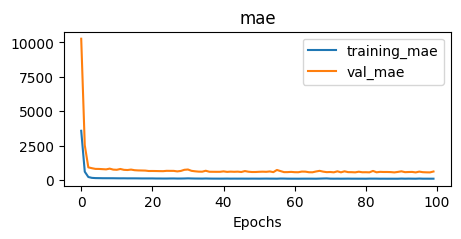

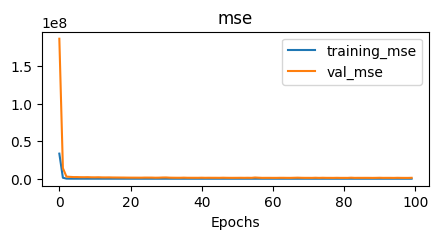

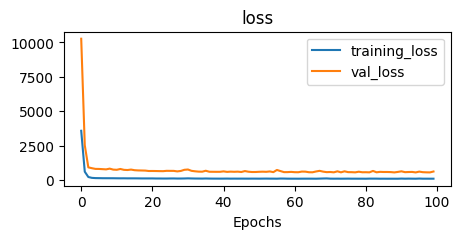

In [42]:
plot_hist_curves([hist_m1], metrics)

In [43]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [44]:
model_1_preds = make_preds(model_1, test_windows)
res_m1 = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
res_m1

18/18 [==============================] - 0s 2ms/step


{'MAE': 564.39703,
 'MASE': 0.9914893,
 'MSE': 1165739.5,
 'rMSE': 1079.6941,
 'MAPE': 2.5309803}

In [45]:
res_m0

{'MAE': 567.9802,
 'MASE': 0.99957,
 'MSE': 1147547.0,
 'rMSE': 1071.2362,
 'MAPE': 2.516525}

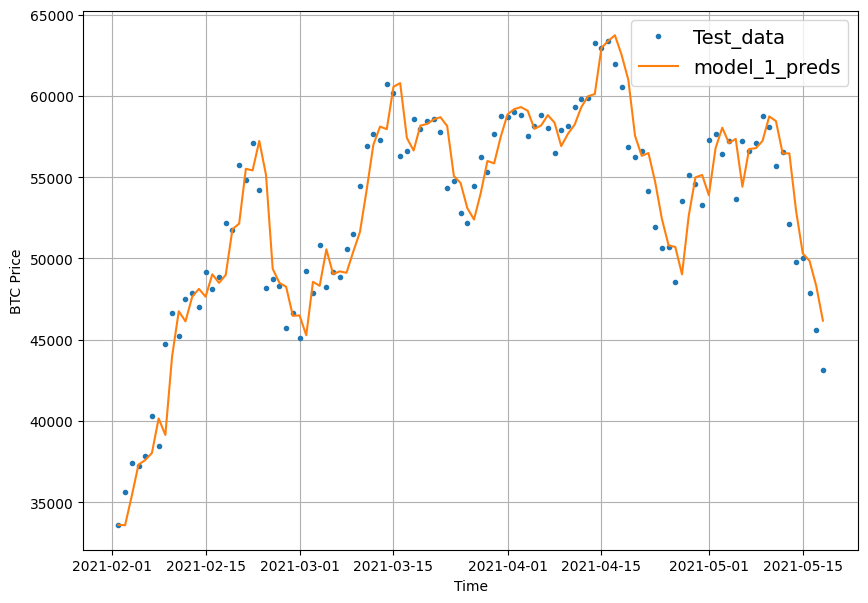

In [46]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model_2: Dense (horizon=1, window=30)

In [47]:
HORIZON = 1
WINDOW_SIZE = 30

In [48]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows_30), len(test_windows_30), len(train_labels_30), len(test_labels_30 )

(2205, 552, 2205, 552)

In [49]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON)
    ],
    name="model_2_dense"
)

model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

hist_m2 = model_2.fit(
    train_windows_30,
    train_labels_30,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows_30, test_labels_30),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

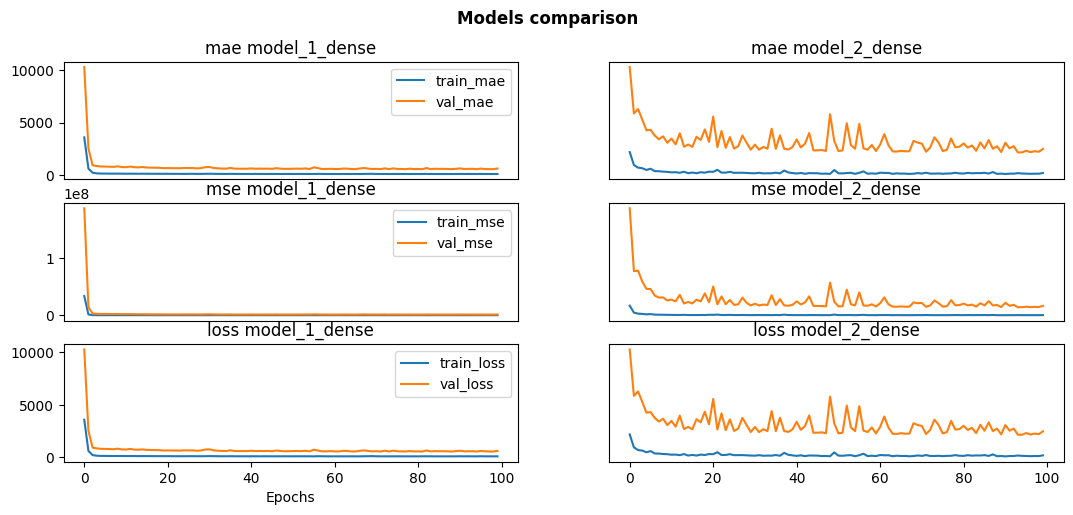

In [50]:
plot_hist_curves([hist_m1, hist_m2], metrics, models_names=[model_1.name, model_2.name])

In [51]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 3ms/step - loss: 588.3315 - mae: 588.3315 - mse: 1241071.1250


[588.33154296875, 588.33154296875, 1241071.125]

In [52]:
model_2_preds = make_preds(model_2, test_windows_30)
res_m2 = evaluate_preds(y_true=tf.squeeze(test_labels_30),
                                 y_pred=model_2_preds)
res_m2

18/18 [==============================] - 0s 2ms/step


{'MAE': 588.33154,
 'MASE': 1.0284094,
 'MSE': 1241071.2,
 'rMSE': 1114.0338,
 'MAPE': 2.656754}

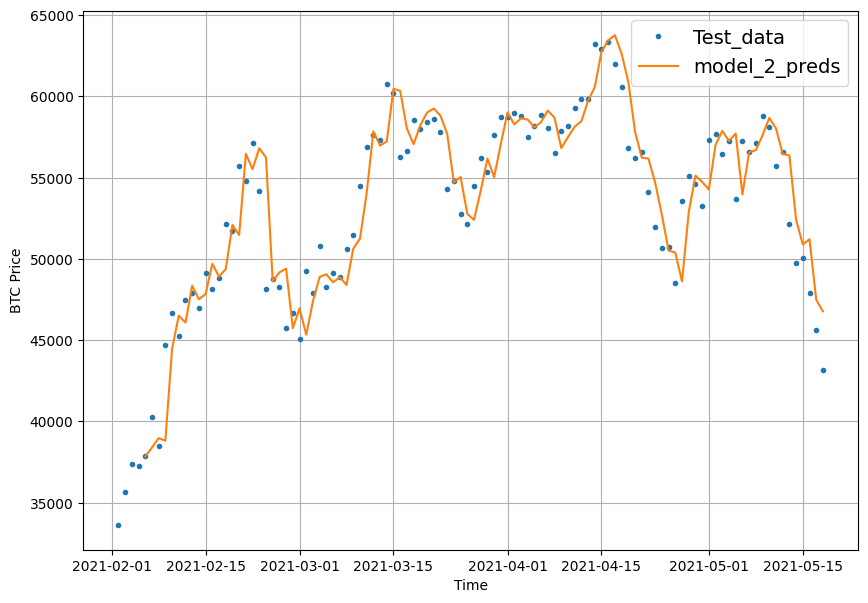

In [53]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows_30):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

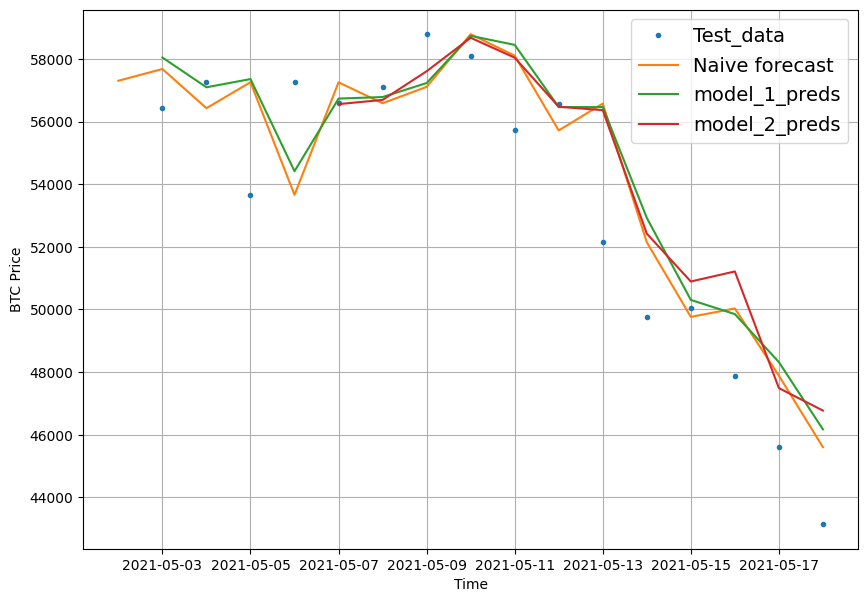

In [54]:
offset = 540
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")
plot_time_series(timesteps=X_test[-len(test_windows_30):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

# Model_3: Dense (horizon=7, window=30)

In [55]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows_7_30, test_windows_7_30, train_labels_7_30, test_labels_7_30 = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows_7_30), len(test_windows_7_30), len(train_labels_7_30), len(test_labels_7_30)

(2200, 551, 2200, 551)

In [56]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON)
    ],
    name="model_3_dense"
)

model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

hist_m3 = model_3.fit(
    train_windows_7_30,
    train_labels_7_30,
    epochs=100,
    batch_size=128,
    verbose=0,
    validation_data=(test_windows_7_30, test_labels_7_30),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

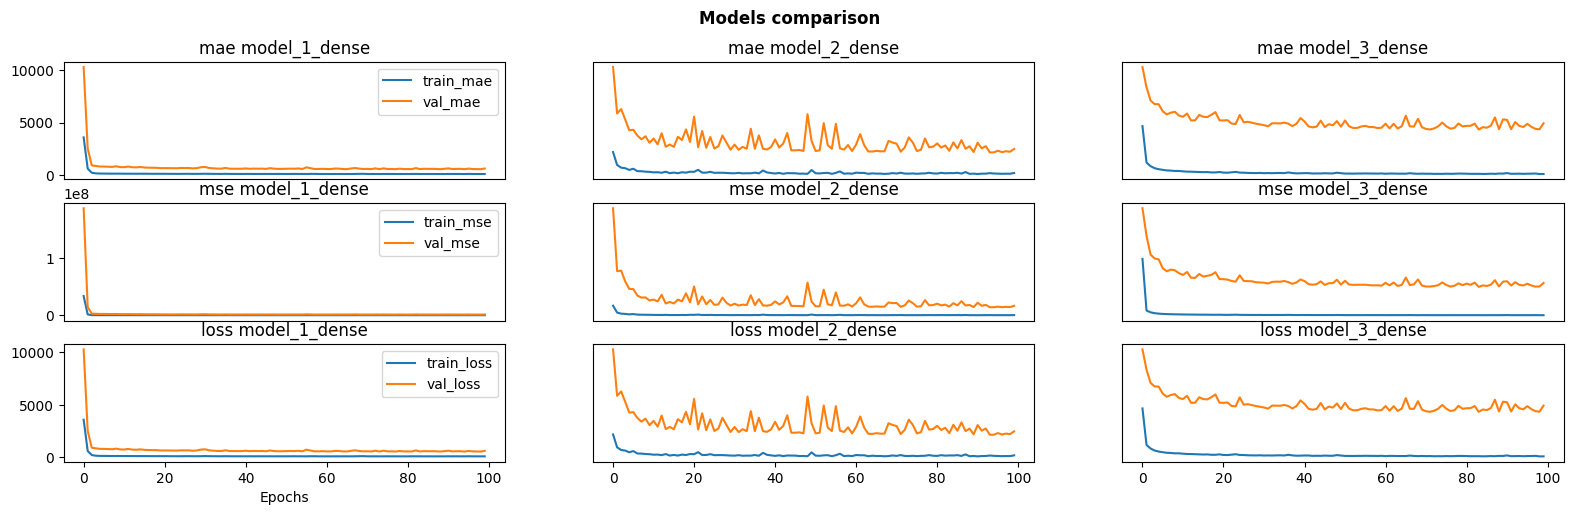

In [57]:
plot_hist_curves([hist_m1, hist_m2, hist_m3], metrics, models_names=[model_1.name, model_2.name, model_3.name])

In [58]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows_7_30, test_labels_7_30)

18/18 [==============================] - 0s 3ms/step - loss: 1236.8334 - mae: 1236.8334 - mse: 5347218.5000


[1236.8333740234375, 1236.8333740234375, 5347218.5]

In [196]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "MAE": mae.numpy(),
      "MSE": mse.numpy(),
      "rMSE": rmse.numpy(),
      "MAPE": mape.numpy(),
      "MASE": mase.numpy()
  }


In [60]:
model_3_preds = make_preds(model_3, test_windows_7_30)
res_m3 = evaluate_preds(y_true=tf.squeeze(test_labels_7_30),
                                 y_pred=model_3_preds.numpy())
res_m3

18/18 [==============================] - 0s 2ms/step


{'MAE': 1236.8334,
 'MSE': 5347218.5,
 'rMSE': 1428.7949,
 'MAPE': 5.5313325,
 'MASE': 2.2008753}

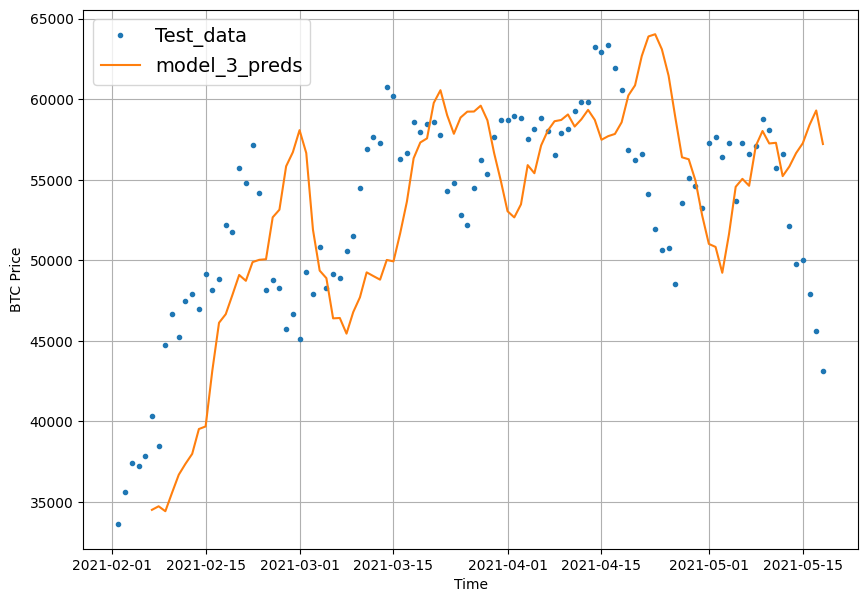

In [61]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(
    timesteps=X_test[-len(test_windows_7_30):],
    values=tf.reduce_mean(model_3_preds, axis=1),
    format="-",
    start=offset,
    label="model_3_preds"
)

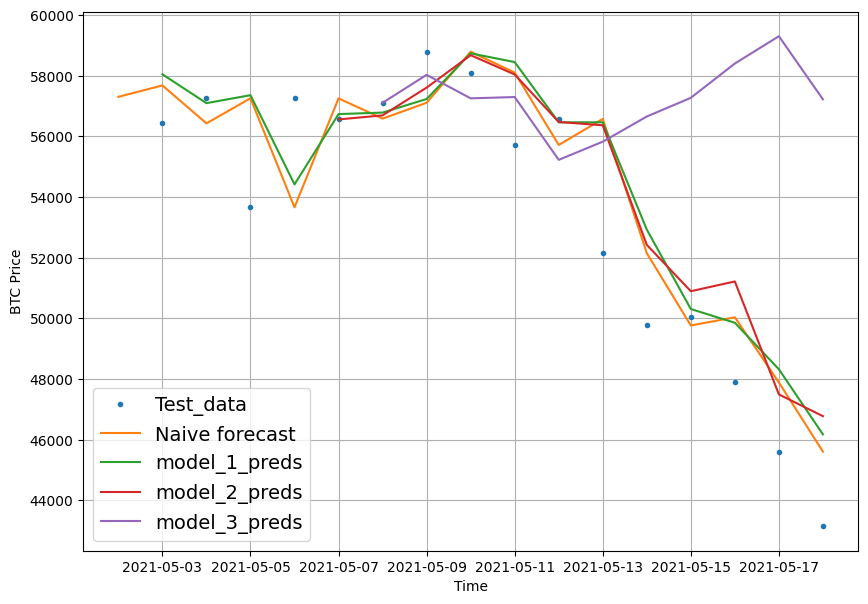

In [62]:
offset = 540
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")
plot_time_series(timesteps=X_test[-len(test_windows_30):], values=model_2_preds, start=offset, format="-", label="model_2_preds")
plot_time_series(
    timesteps=X_test[-len(test_windows_7_30):],
    values=tf.reduce_mean(model_3_preds, axis=1),
    format="-",
    start=offset,
    label="model_3_preds"
)

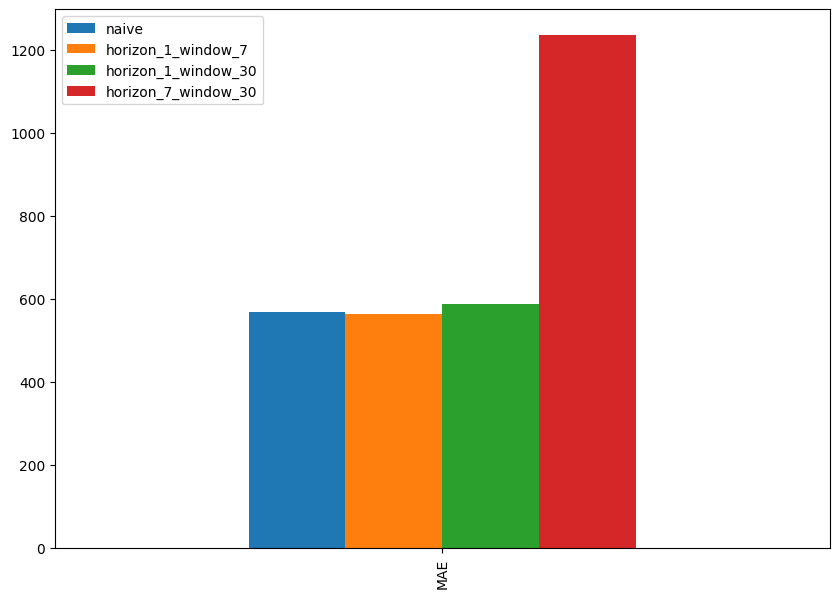

In [63]:
pd.DataFrame({"naive": res_m0["MAE"],
              "horizon_1_window_7": res_m1["MAE"],
              "horizon_1_window_30": res_m2["MAE"],
              "horizon_7_window_30": res_m3["MAE"]}, index=["MAE"]).plot(figsize=(10, 7), kind="bar");

# Model_4: Conv_1D

In [64]:
test_windows[0].shape

(7,)

In [65]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [66]:
expand_dims_layer(test_windows[0]).shape

TensorShape([7, 1])

In [67]:
expand_dims_layer(test_windows[0])

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[9290.896],
       [9202.415],
       [9369.628],
       [9326.6  ],
       [9335.752],
       [9226.485],
       [8794.358]], dtype=float32)>

In [68]:
tf.random.set_seed(42)

inputs = layers.Input(test_windows[0].shape, dtype=tf.float32)
expanded_dims = expand_dims_layer(inputs)
x = layers.Conv1D(128, kernel_size=5, padding="causal", activation="relu")(expanded_dims)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(HORIZON, activation="linear")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Conv1D")

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mae',
    metrics=metrics
)

hist_m4 = model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)],
    verbose=0
)

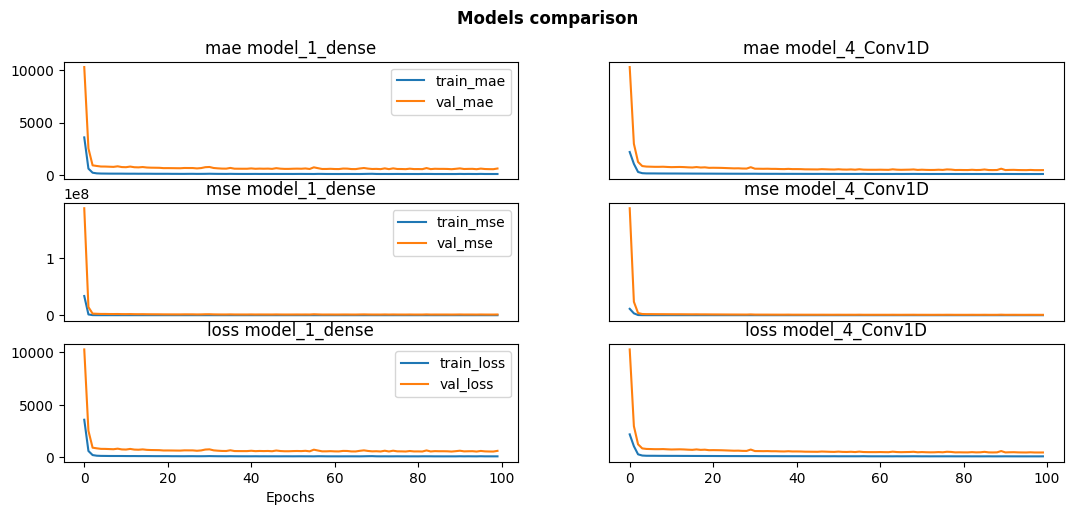

In [69]:
plot_hist_curves([hist_m1, hist_m4], metrics, models_names=[model_1.name, model_4.name])

In [70]:
model_4_preds = make_preds(model_4, test_windows)
res_m4 = evaluate_preds(y_true=test_labels,
                                 y_pred=model_4_preds)
res_m4

18/18 [==============================] - 0s 3ms/step


{'MAE': 591.04285,
 'MSE': 1238796.5,
 'rMSE': 597.8544,
 'MAPE': 2.6510234,
 'MASE': 1.0382986}

In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 588.2755 - mae: 588.2755 - mse: 1234478.3750


[588.2755126953125, 588.2755126953125, 1234478.375]

In [72]:
model_4_preds = make_preds(model_4, test_windows)
res_m4 = evaluate_preds(y_true=test_labels,
                                 y_pred=model_4_preds)
res_m4

18/18 [==============================] - 0s 2ms/step


{'MAE': 588.2755,
 'MSE': 1234478.2,
 'rMSE': 592.3031,
 'MAPE': 2.639511,
 'MASE': 1.0334371}

In [73]:
model_4_preds.shape, tf.reduce_mean(model_4_preds, axis=1).shape

(TensorShape([556, 7]), TensorShape([556]))

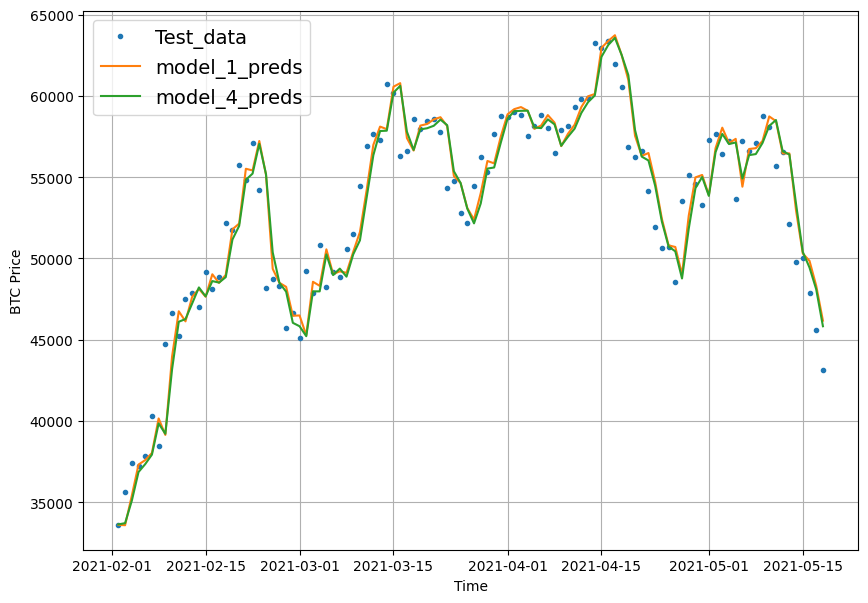

In [74]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_4_preds, axis=1), start=offset, format="-", label="model_4_preds")

# Model_5: LSTM

In [75]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        layers.LSTM(128, activation="relu"),
        layers.Dense(HORIZON)
    ], name="model_5_LSTM"
)


model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

hist_m5 = model_5.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

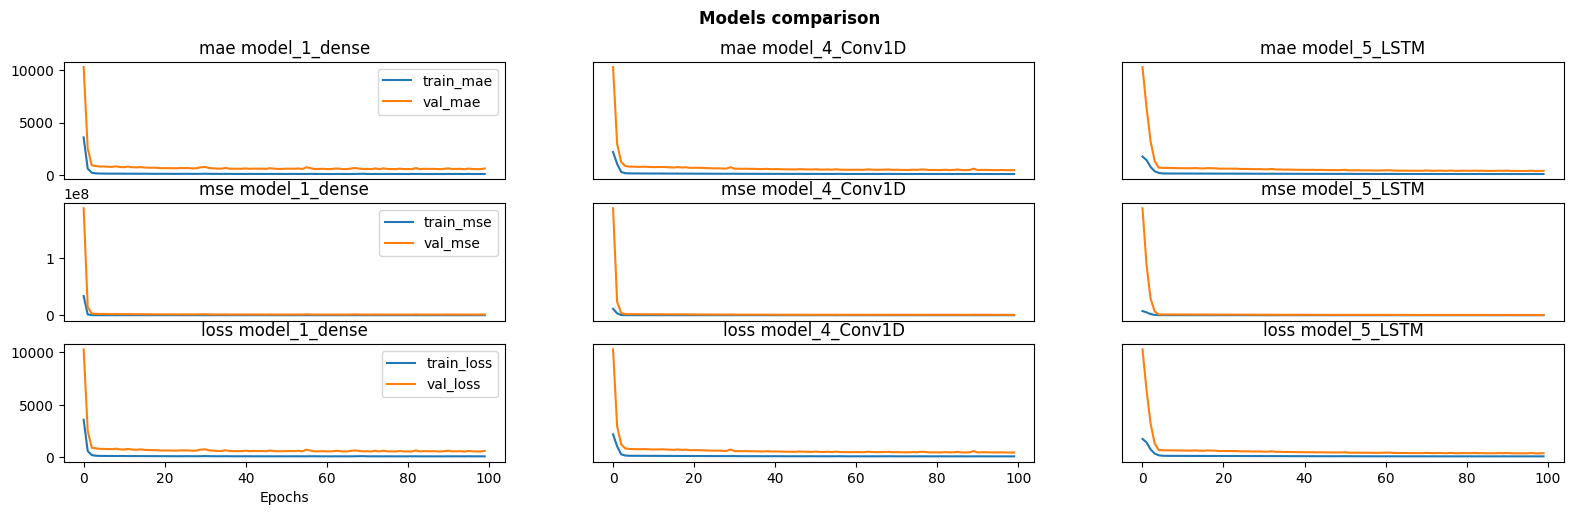

In [76]:
plot_hist_curves([hist_m1, hist_m4, hist_m5], metrics, models_names=[model_1.name, model_4.name, model_5.name])

In [77]:
model_5_preds = make_preds(model_5, test_windows)
res_m5 = evaluate_preds(y_true=test_labels,
                                 y_pred=model_5_preds)
res_m5

18/18 [==============================] - 0s 3ms/step


{'MAE': 624.64734,
 'MSE': 1344646.8,
 'rMSE': 630.06604,
 'MAPE': 2.861115,
 'MASE': 1.0973324}

In [78]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 596.3153 - mae: 596.3153 - mse: 1267638.0000


[596.3153076171875, 596.3153076171875, 1267638.0]

In [79]:
model_5_preds = make_preds(model_5, test_windows)
res_m5 = evaluate_preds(y_true=test_labels,
                                 y_pred=model_5_preds)
res_m5

18/18 [==============================] - 0s 2ms/step


{'MAE': 596.3153,
 'MSE': 1267637.9,
 'rMSE': 601.3977,
 'MAPE': 2.6814713,
 'MASE': 1.0475608}

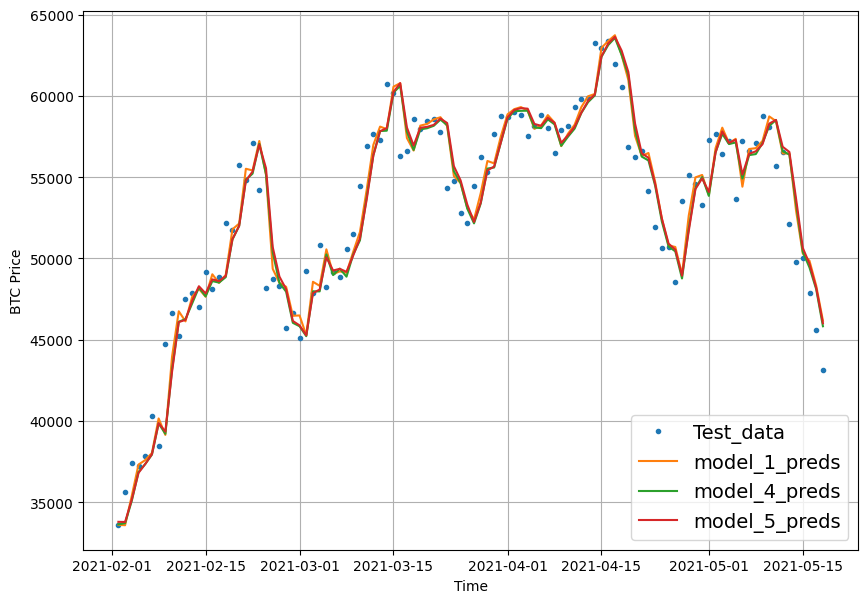

In [80]:
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_4_preds, axis=1), start=offset, format="-", label="model_4_preds")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_5_preds, axis=1), start=offset, format="-", label="model_5_preds")

# Model_6: Multivariate model

In [81]:
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25
block_reward_3 = 12.
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [82]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [83]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


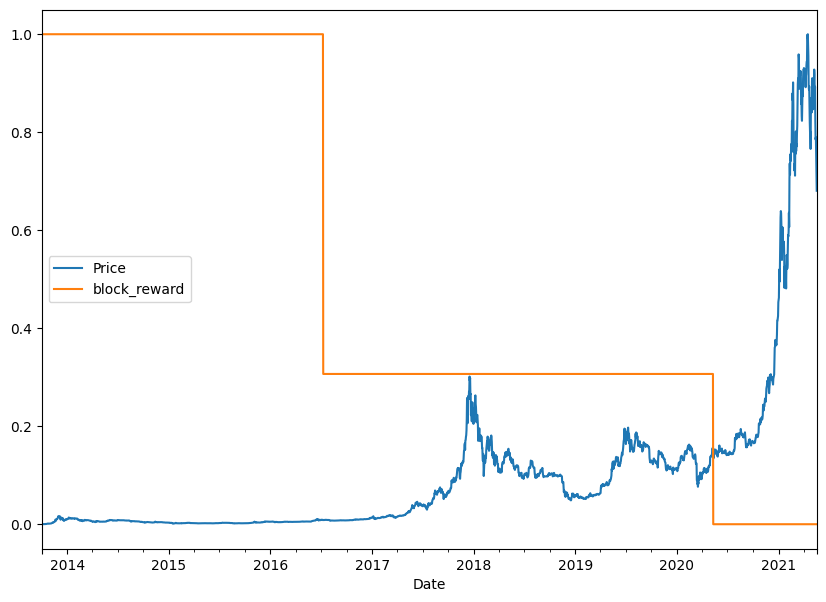

In [84]:
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [85]:
HORIZON = 1
WINDOW_SIZE = 7

In [86]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [87]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [88]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [89]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON, activation="linear")
    ],
    name="model_6_dense"
)

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mae',
    metrics=metrics
)

hist_m6 = model_6.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)],
    verbose=0
)

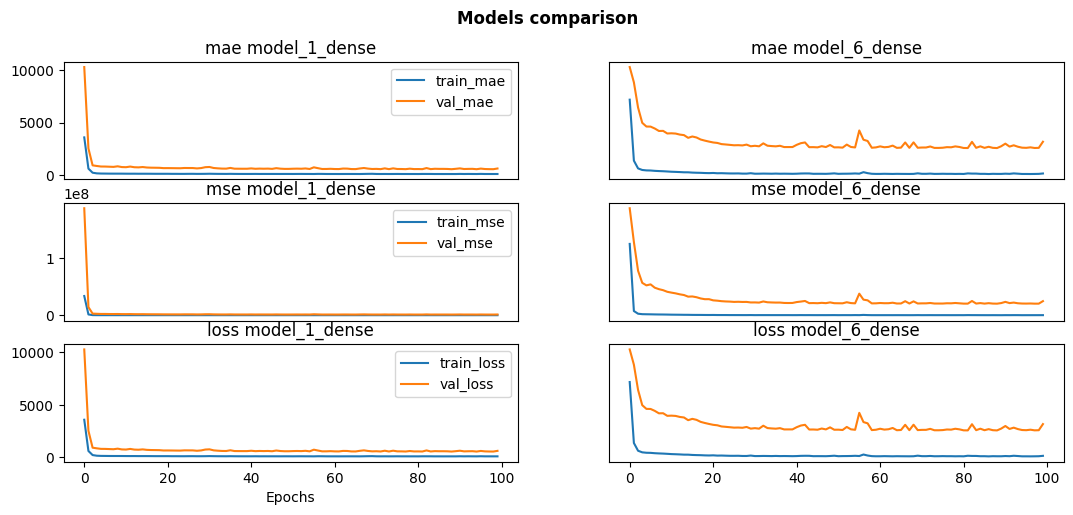

In [90]:
plot_hist_curves([hist_m1, hist_m6], metrics, models_names=[model_1.name, model_6.name])

In [91]:
model_6_preds = make_preds(model_6, X_test)
res_m6_last = evaluate_preds(y_true=y_test,
                        y_pred=model_6_preds)

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense/")
print(model_6.evaluate(X_test, y_test))

model_6_preds = make_preds(model_6, X_test)
res_m6 = evaluate_preds(y_true=y_test,
                        y_pred=model_6_preds)

print('\nResults'+'\n'+'-'*20)
print('Last:', res_m6_last, '\nBest:', res_m6)

18/18 [==============================] - 0s 3ms/step - loss: 563.1238 - mae: 563.1238 - mse: 1152243.8750
[563.123779296875, 563.123779296875, 1152243.875]
18/18 [==============================] - 0s 2ms/step

Results
--------------------
Last: {'MAE': 674.59436, 'MSE': 1390871.9, 'rMSE': 1179.3523, 'MAPE': 3.115875, 'MASE': 1.1850754} 
Best: {'MAE': 563.12384, 'MSE': 1152243.9, 'rMSE': 1073.4263, 'MAPE': 2.524783, 'MASE': 0.9892526}


In [92]:
print('Naive_model:', res_m0)

Naive_model: {'MAE': 567.9802, 'MASE': 0.99957, 'MSE': 1147547.0, 'rMSE': 1071.2362, 'MAPE': 2.516525}


# Model_7: NBeats

In [93]:
NBeatsBlockCount=0
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(
          self,
          input_size,
          theta_size,
          horizon,
          n_neurons,
          n_layers,
          **kwargs
    ):
    global NBeatsBlockCount
    NBeatsBlockCount+=1
    self.id = NBeatsBlockCount

    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    try:
      self.hidden = [Dense(n_neurons, activation='relu', name=f'{kwargs.name}_dense_{x}') for x in range(n_layers)]
    except AttributeError:
      self.hidden = [Dense(n_neurons, activation='relu', name=f'NBeats_block{self.id}_dense_{x}') for x in range(n_layers)]
    self.theta_layer = Dense(theta_size, activation='linear', name=f'NBeatsBlock{self.id}_theta')

  def __del__(self):
    global NBeatsBlockCount
    NBeatsBlockCount-=1

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [94]:
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4,
)

In [95]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# Data will be just a random weights
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.3558111  -0.24550396 -0.3004487  -0.2724195   0.7856317   0.22050402
  0.3496019 ]
Forecast: -0.39341944456100464


In [97]:
HORIZON = 1
WINDOW_SIZE = 7
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [98]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [99]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [100]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [101]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])

added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]



Epoch 156: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 256: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 47s, sys: 2.18 s, total: 1min 49s
Wall time: 2min 1s


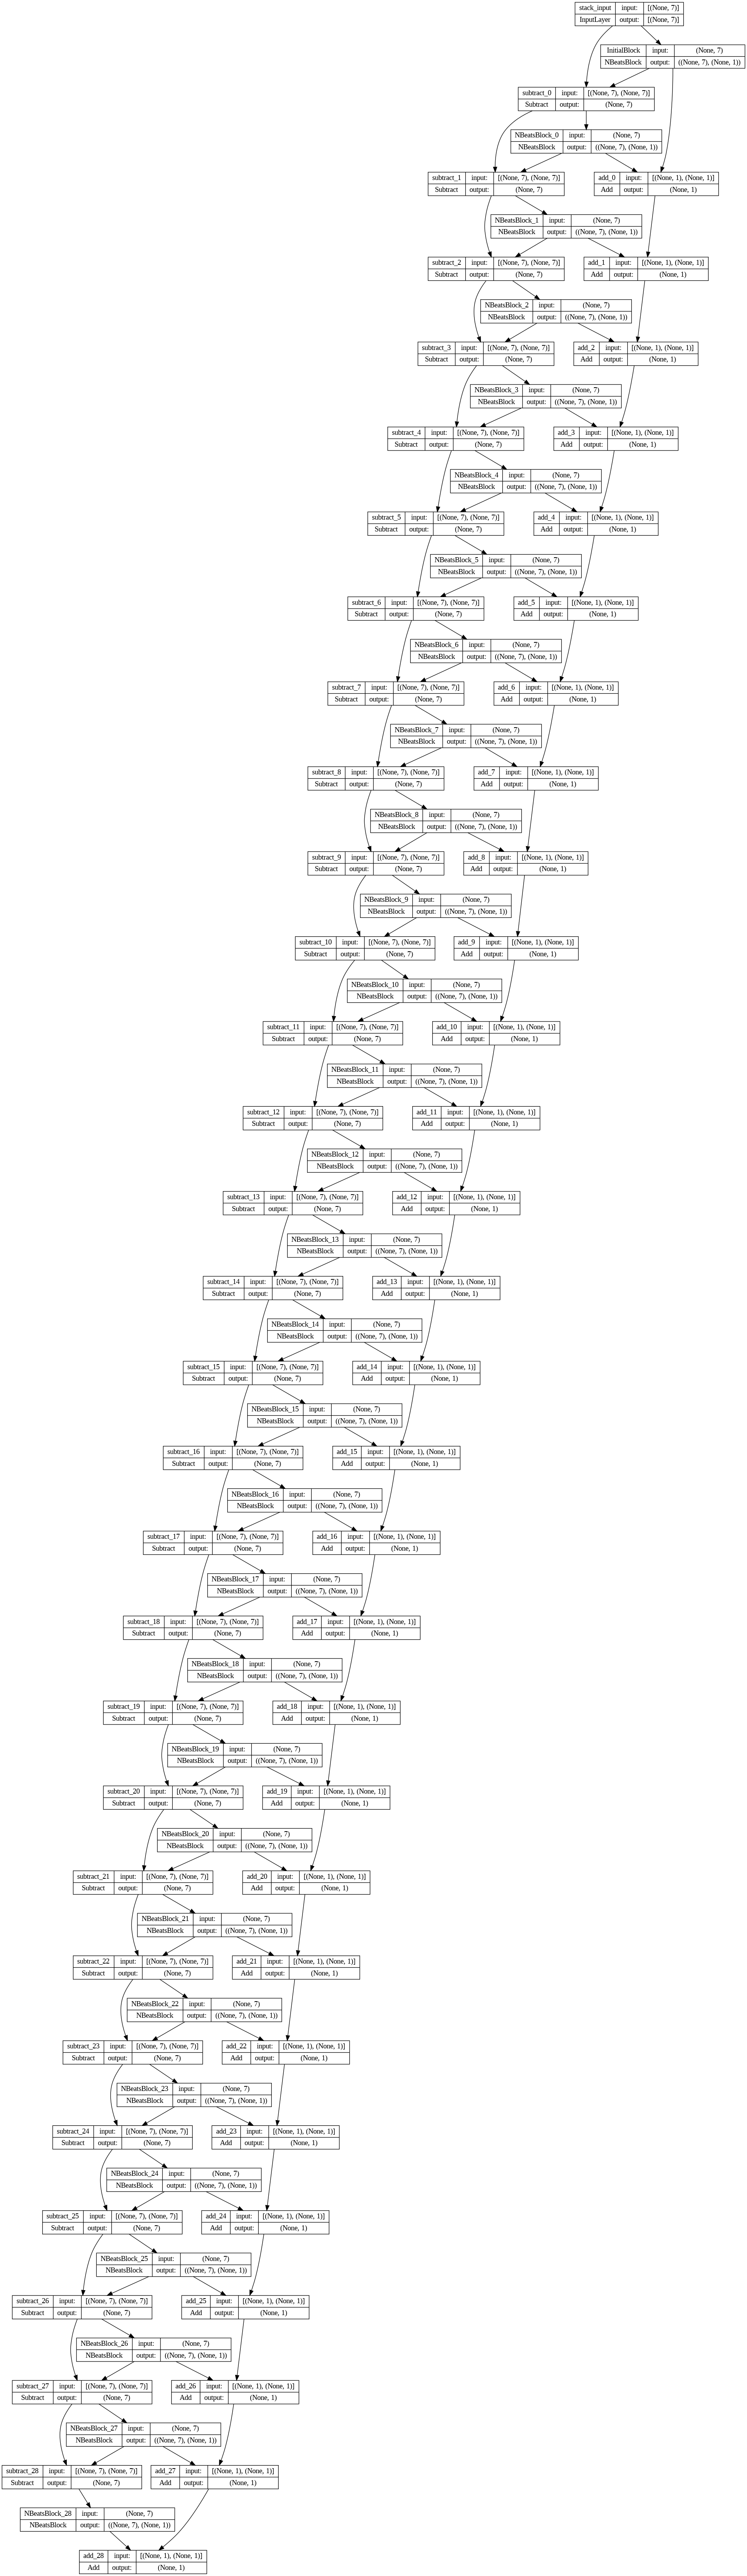

In [102]:
%%time
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(
    input_size=INPUT_SIZE,
    theta_size=THETA_SIZE,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    name="InitialBlock"
)

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_0")

for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted higher
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i+1}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(
    inputs=stack_input,
    outputs=forecast,
    name="model_7_NBEATS"
)

model_7.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

hist_m7 = model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=0,
    # create_model_checkpoint() not used due to time consumption
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1) # Reduce learning rate when a metric has stopped improving
    ]
)

tf.keras.utils.plot_model(model_7, show_shapes=True)

In [103]:
ev_m7 = model_7.evaluate(test_dataset)
model_7_preds = make_preds(model_7, test_dataset)
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

1/1 [==============================] - 2s 2s/step


{'MAE': 567.40564,
 'MSE': 1148498.2,
 'rMSE': 1071.68,
 'MAPE': 2.592232,
 'MASE': 0.99677455}

In [104]:
model_7.save(model_7.name)

# Model_8: Ensemble

In [105]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["mae", "mse"]
      )

      model.fit(
          train_data,
          epochs=num_epochs,
          verbose=0,
          validation_data=test_data,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  patience=200,
                  restore_best_weights=True
              ),
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor="val_loss",
                  patience=100,
                  verbose=1
              )
          ]
      )

      ensemble_models.append(model)

  return ensemble_models

In [106]:
%%time
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 743: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 843: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 254: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 354: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 198: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 647: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 747: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 643: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 743: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

In [107]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [108]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


In [109]:
ensemble_results = evaluate_preds(
    y_true=y_test,
    y_pred=np.median(ensemble_preds, axis=0)
)
ensemble_results

{'MAE': 569.5364,
 'MSE': 1155153.6,
 'rMSE': 1074.7808,
 'MAPE': 2.5927072,
 'MASE': 1.0005177}

In [110]:
def get_lower_upper_bounds(model_preds):
  std_deviation = tf.math.reduce_std(model_preds, axis=0)
  confidence_95p = std_deviation * 1.96
  lower, upper = tf.reduce_mean(model_preds, axis=0) - confidence_95p, tf.reduce_mean(model_preds, axis=0) + confidence_95p
  return lower, upper

lower_bounds, upper_bounds = get_lower_upper_bounds(model_preds=ensemble_preds)

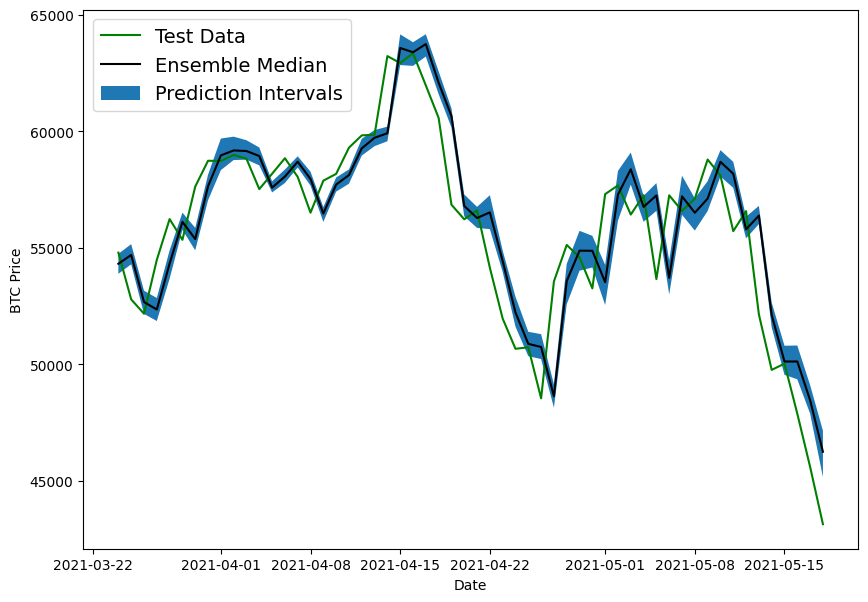

In [111]:
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(
    X_test.index[offset:],
    (lower_bounds)[offset:],
    (upper_bounds)[offset:], label="Prediction Intervals"
)
plt.legend(loc="upper left", fontsize=14);

# Model_9: Future forecasting

In [112]:
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [113]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

BATCH_SIZE = 1024
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [132]:
model_9 = tf.keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON)
    ],
    name='model_9'
)

model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

hist_m9 = model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

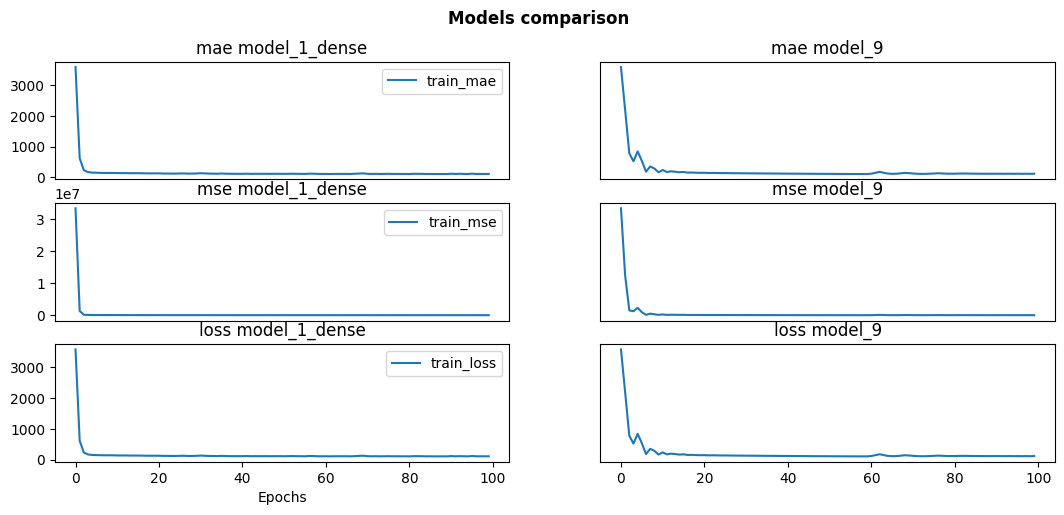

In [122]:
plot_hist_curves([hist_m1, hist_m9], metrics, models_names=[model_1.name, model_9.name], val_data=False)

In [164]:
# Normally the model would be retrained after every prediction but i have no future data
def make_future_forecast(into_future, model, values, window_size, verbose=2):
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  values_copy = values.copy()
  future_forecast = []

  for x in range(into_future):
    pred = model.predict(np.expand_dims(values_copy[-window_size:], axis=0))
    if verbose==2:
      print(f'Iterration {x}: \n\tvalues: {values_copy[-window_size:]} \n\tprediction: {pred}')

    values_copy = np.append(values_copy, pred)
    future_forecast.append(pred)

  if verbose:
    print()
    print('Predictions:')
    print('-'*15)
    for x, pred in enumerate(future_forecast):
      print(f'Day {x+1}: {pred}')

  return future_forecast

In [173]:
INTO_FUTURE = 100
future_forecast = make_future_forecast(
    INTO_FUTURE,
    model_9,
    y_all,
    WINDOW_SIZE,
    verbose=1
)

1/1 [==============================] - 0s 24ms/step

Predictions:
---------------
Day 1: [[55488.484]]
Day 2: [[52140.555]]
Day 3: [[47292.51]]
Day 4: [[48051.457]]
Day 5: [[50057.4]]
Day 6: [[46269.31]]
Day 7: [[47155.016]]
Day 8: [[54965.574]]
Day 9: [[51216.54]]
Day 10: [[45703.656]]
Day 11: [[48569.727]]
Day 12: [[51679.113]]
Day 13: [[47406.15]]
Day 14: [[48703.02]]
Day 15: [[54554.78]]
Day 16: [[50323.527]]
Day 17: [[45353.477]]
Day 18: [[49967.598]]
Day 19: [[52922.797]]
Day 20: [[48010.953]]
Day 21: [[49231.066]]
Day 22: [[54381.188]]
Day 23: [[49867.234]]
Day 24: [[45827.125]]
Day 25: [[51499.32]]
Day 26: [[53624.875]]
Day 27: [[48109.31]]
Day 28: [[49535.76]]
Day 29: [[54509.027]]
Day 30: [[49749.414]]
Day 31: [[46648.535]]
Day 32: [[52740.19]]
Day 33: [[53880.805]]
Day 34: [[48001.03]]
Day 35: [[49986.656]]
Day 36: [[54883.953]]
Day 37: [[49869.914]]
Day 38: [[47479.57]]
Day 39: [[53702.17]]
Day 40: [[53890.688]]
Day 41: [[47935.805]]
Day 42: [[50659.418]]
Day 43: [[55371.42

In [174]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [175]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [176]:
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
       '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
       '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
       '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
       '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
       '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23',
       '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27',
       '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
       '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05',
       '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09',
       '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13',
       '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17',
       '2021-07-18', '2021-07-19', '2021-07-20', '2021-

In [178]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-18', '2021-05-19', '2021-05-20',
        '2021-05-21', '2021-05-22', '2021-05-23', '2021-05-24',
        '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28',
        '2021-05-29', '2021-05-30', '2021-05-31', '2021-06-01',
        '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-05',
        '2021-06-06', '2021-06-07', '2021-06-08', '2021-06-09',
        '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
        '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
        '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21',
        '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
        '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29',
        '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03',
        '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07',
        '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11',
        '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15',
        '2021-07-16', '2021-07-17', '202

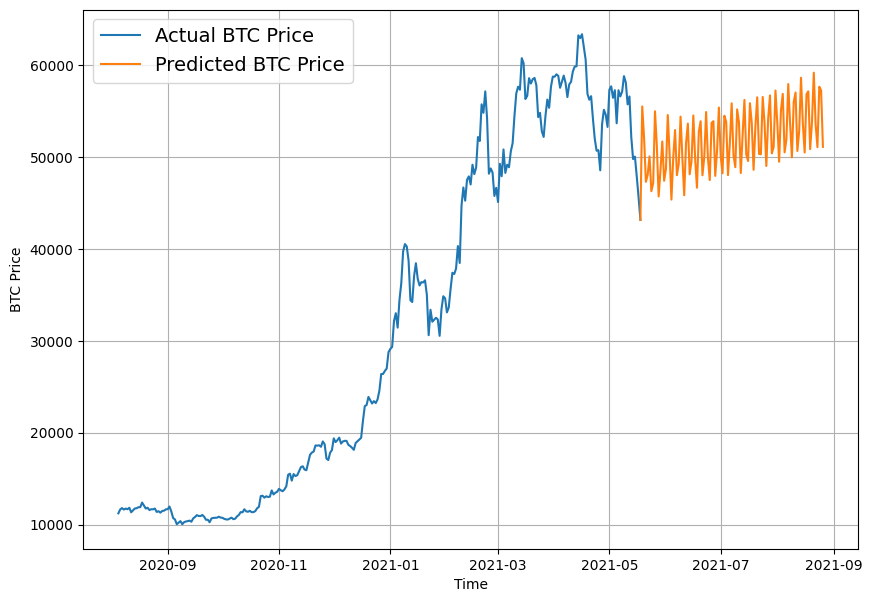

In [179]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

# Model_10: Turkey Problem visualisation

In [182]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

btc_timesteps_turkey = np.array(bitcoin_prices.index)

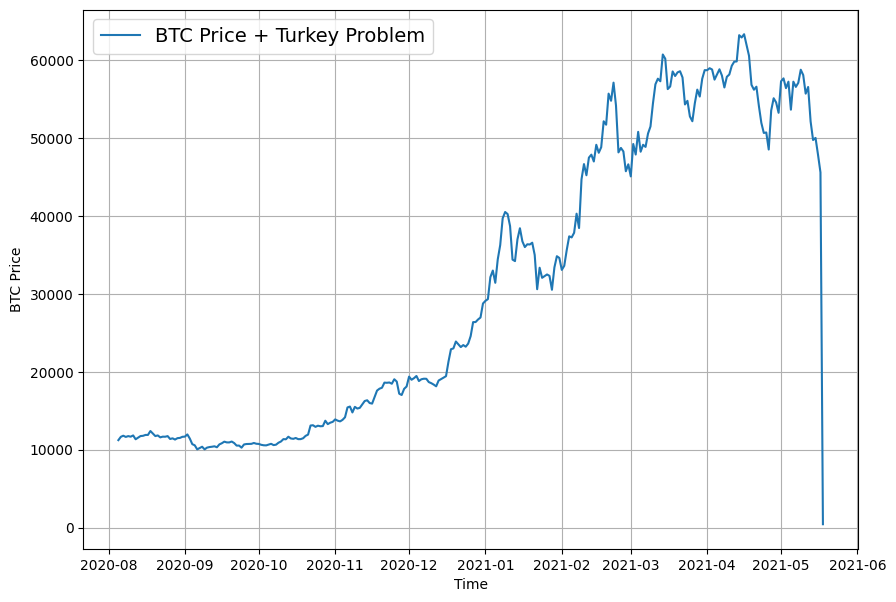

In [183]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [184]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [200]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=metrics)
hist_m10 = turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [201]:
turkey_model.evaluate(X_test, y_test)
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 640.1669 - mae: 640.1669 - mse: 4912323.5000


[640.1669311523438, 640.1669311523438, 4912323.5]

In [202]:
turkey_preds = make_preds(turkey_model, X_test)
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

18/18 [==============================] - 0s 2ms/step


{'MAE': 17138.09,
 'MSE': 615039940.0,
 'rMSE': 23730.367,
 'MAPE': 121.47266,
 'MASE': 26.521252}

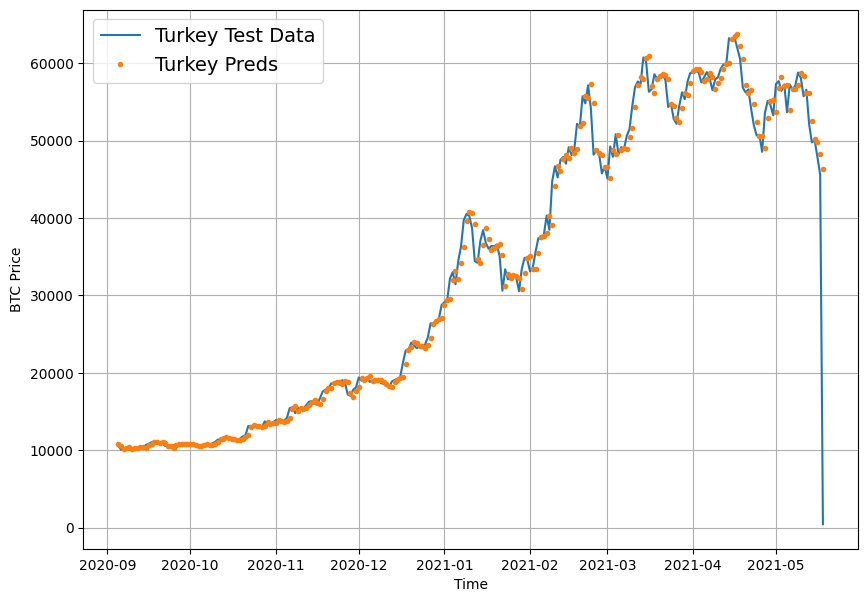

In [203]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

# Comparing models

In [205]:
model_results = pd.DataFrame({"naive_model": res_m0,
                              "model_1_dense_w7_h1": res_m1,
                              "model_2_dense_w30_h1": res_m2,
                              "model_3_dense_w30_h7": res_m3,
                              "model_4_CONV1D": res_m4,
                              "model_5_LSTM": res_m5,
                              "model_6_multivariate": res_m6,
                              "model_7_NBEATs": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "turkey_model": turkey_results}).T
model_results.head(10)

,MAE,MASE,MSE,rMSE,MAPE
naive_model,567.980225,0.999570,1.147547e+06,1071.236206,2.516525
model_1_dense_w7_h1,564.397034,0.991489,1.165740e+06,1079.694092,2.530980
model_2_dense_w30_h1,588.331543,1.028409,1.241071e+06,1114.033813,2.656754
model_3_dense_w30_h7,1236.833374,2.200875,5.347218e+06,1428.794922,5.531332
model_4_CONV1D,588.275513,1.033437,1.234478e+06,592.303101,2.639511
model_5_LSTM,596.315308,1.047561,1.267638e+06,601.397705,2.681471
model_6_multivariate,563.123840,0.989253,1.152244e+06,1073.426270,2.524783
model_7_NBEATs,567.405640,0.996775,1.148498e+06,1071.680054,2.592232
model_8_ensemble,569.536377,1.000518,1.155154e+06,1074.780762,2.592707
turkey_model,17138.089844,26.521252,6.150399e+08,23730.367188,121.472656


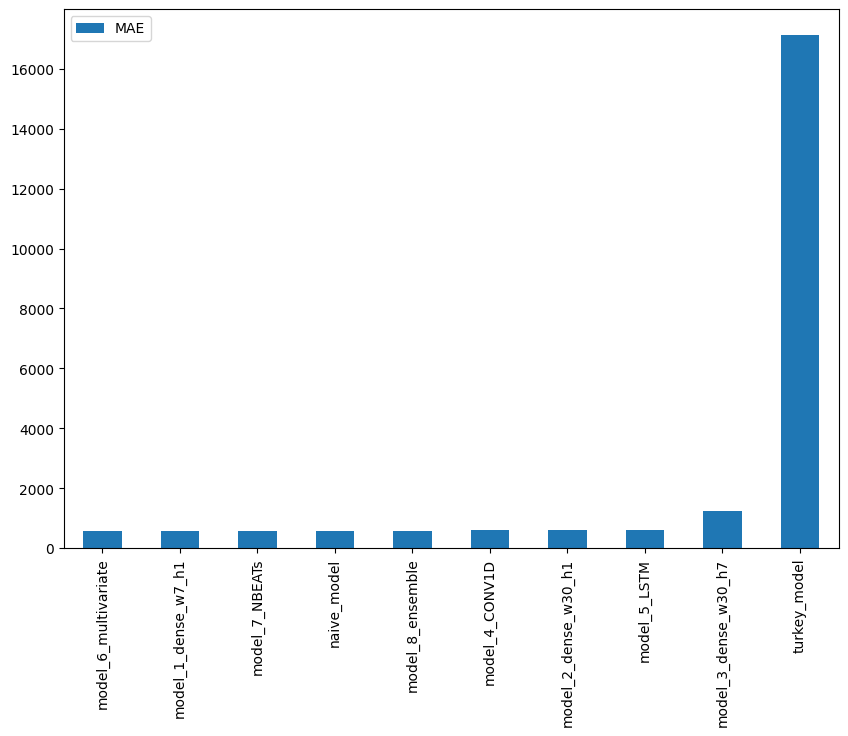

In [207]:
model_results[["MAE"]].sort_values(by="MAE").plot(figsize=(10, 7), kind="bar");